In [450]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, FFMpegWriter

In [451]:
#  Parameters
grid_size = 20  # Length of the grid
iterations = 100  # Total number of iterations
initial_cancer = 0  # Initial number of cancer cells
cancer_add_interval = 10  # Interval for adding cancer cells in Stage 0
fitness_h = 1.0  # Fitness for healthy cells
fitness_h = 1.0  # Fitness for healthy cells
fitness_c = 1.1  # Fitness for cancer cells
immune_threshold = 15  # Cancer neighbor threshold for adding immune cells
num_stages = 5  # Number of cancer stages
immune_effectiveness = 0.5  # Effectiveness of immune cells against cancer

# States and their corresponding colors
cell_colors = {
    1: 'blue',     # Healthy
    2: 'red',      # Cancer
    3: 'green',    # Immune
}

In [452]:
'''
- Stage 0: all healthy 
- Stage 1 50/50 for health and cancer cell
- Stage 2 60/40 cancer and healthy
- Add immune cells 
- Stage 3 70/30 
- Add immune cells --> number of immune cellls --> cancer cells /2 
- Stage 4 70/30 --> randomness
'''

'\n- Stage 0: all healthy \n- Stage 1 50/50 for health and cancer cell\n- Stage 2 60/40 cancer and healthy\n- Add immune cells \n- Stage 3 70/30 \n- Add immune cells --> number of immune cellls --> cancer cells /2 \n- Stage 4 70/30 --> randomness\n'

In [453]:
# Initialize the grid
def initialize_grid():
    """Initialize the grid with all healthy cells (Stage 0)."""
    grid = np.ones((grid_size, grid_size), dtype=int)  # All cells healthy
    return grid, []  # Return grid and an empty cancer positions list

In [454]:
# Determine cancer stage based on grid proportions
def get_stage(cancer_count, total_cells):
    """Determine the current stage of cancer."""
    proportion = cancer_count / total_cells
    if proportion == 0:
        return 0
    elif proportion <= 0.20:  # Loosen thresholds for Stage 1
        return 1
    elif proportion <= 0.5:  # Loosen thresholds for Stage 2
        return 2
    elif proportion <= 0.70:  # Loosen thresholds for Stage 3
        return 3
    else:
        return 4

In [455]:
# Get probabilities for transitions based on the stage
def get_stage_probabilities(stage):
    """Define transition probabilities based on stage."""
    return {
        'P_H_to_C': 0.1 + 0.05 * stage,  # Increased probabilities
        'P_C_to_H': 0.02 - 0.002 * stage,  # Slight decrease as stage increases
        'P_C_to_I': 0.0 if stage < 2 else 0.01 + 0.01 * (stage - 2)
    }

In [456]:
# Moran process for cell interactions
def moran_process(grid, fitness_h, fitness_c):
    """Apply the Moran process with fitness ratios."""
    total_cells = grid_size ** 2
    cancer_count = np.count_nonzero(grid == 2)
    healthy_count = total_cells - cancer_count - np.count_nonzero(grid == 3)

    for _ in range(total_cells):
        x, y = np.random.randint(0, grid_size, size=2)
        current_cell = grid[x, y]

        # Skip immune cells
        if current_cell == 3:
            continue

        neighbors = [(i, j) for i in range(max(0, x-1), min(grid_size, x+2))
                     for j in range(max(0, y-1), min(grid_size, y+2))]
        neighbor_x, neighbor_y = neighbors[np.random.randint(len(neighbors))]
        neighbor_cell = grid[neighbor_x, neighbor_y]

        if current_cell == 2 and neighbor_cell == 1:  # Cancer to Healthy
            if np.random.rand() < (cancer_count * fitness_c / (cancer_count * fitness_c + healthy_count * fitness_h)):
                grid[neighbor_x, neighbor_y] = 2
    return grid

In [457]:
def spread_cancer(grid, stage, cancer_origin):
    """Spread cancer dynamically based on stage."""
    new_grid = grid.copy()
    probs = get_probabilities(stage)
    cancer_positions = np.argwhere(grid == 2)

    for x, y in cancer_positions:
        neighbors = [(i, j) for i in range(max(0, x-1), min(grid_size, x+2))
                     for j in range(max(0, y-1), min(grid_size, y+2))]
        for nx, ny in neighbors:
            if grid[nx, ny] == 1:  # Healthy to Cancer
                if np.random.rand() < probs['P_H_to_C']:
                    new_grid[nx, ny] = 2

        # Introduce immune cells after Stage 2
        if stage >= 2:
            cancer_neighbors = sum(grid[i, j] == 2 for i, j in neighbors)
            if cancer_neighbors >= immune_threshold:
                for nx, ny in neighbors:
                    if grid[nx, ny] == 1 and np.random.rand() < probs['P_C_to_I']:
                        new_grid[nx, ny] = 3  # Add immune cell
    return new_grid

In [458]:
# Markov transitions for state changes
def apply_markov_transitions(grid, stage, immune_threshold):
    """Apply Markov transitions to model state changes."""
    new_grid = grid.copy()
    probs = get_stage_probabilities(stage)
    cancer_positions = np.argwhere(grid == 2)

    for x, y in cancer_positions:
        neighbors = [(i, j) for i in range(max(0, x-1), min(grid_size, x+2))
                     for j in range(max(0, y-1), min(grid_size, y+2))]
        for nx, ny in neighbors:
            if grid[nx, ny] == 1 and np.random.rand() < probs['P_H_to_C']:
                new_grid[nx, ny] = 2  # Healthy to Cancer
            elif grid[nx, ny] == 2 and np.random.rand() < probs['P_C_to_H']:
                new_grid[nx, ny] = 1  # Cancer to Healthy

        # Immune response introduction if cancer cells around exceed threshold
        if len(cancer_positions) > immune_threshold:
            immune_count = len([n for n in neighbors if grid[n[0], n[1]] == 3])
            if immune_count < len(cancer_positions) / 10:  # Add few immune cells
                for nx, ny in neighbors:
                    if grid[nx, ny] == 1 and np.random.rand() < probs['P_C_to_H']:
                        new_grid[nx, ny] = 3
    return new_grid

In [459]:
# Visualization function
def draw_grid(grid, ax):
    """Draw the grid."""
    ax.clear()
    ax.set_xlim(-0.5, grid_size - 0.5)
    ax.set_ylim(-0.5, grid_size - 0.5)
    ax.set_xticks([])
    ax.set_yticks([])
    for x in range(grid_size):
        for y in range(grid_size):
            color = cell_colors[grid[x, y]]
            circle = plt.Circle((y, grid_size - 1 - x), 0.4, color=color)
            ax.add_patch(circle)

In [460]:
# Initialize simulation
grid, initial_cancer_positions = initialize_grid()
healthy_counts = []
cancer_counts = []
immune_counts = []

In [461]:
# Animation initialization
def init():
    line1.set_data([], [])
    line2.set_data([], [])
    line3.set_data([], [])
    return line1, line2, line3

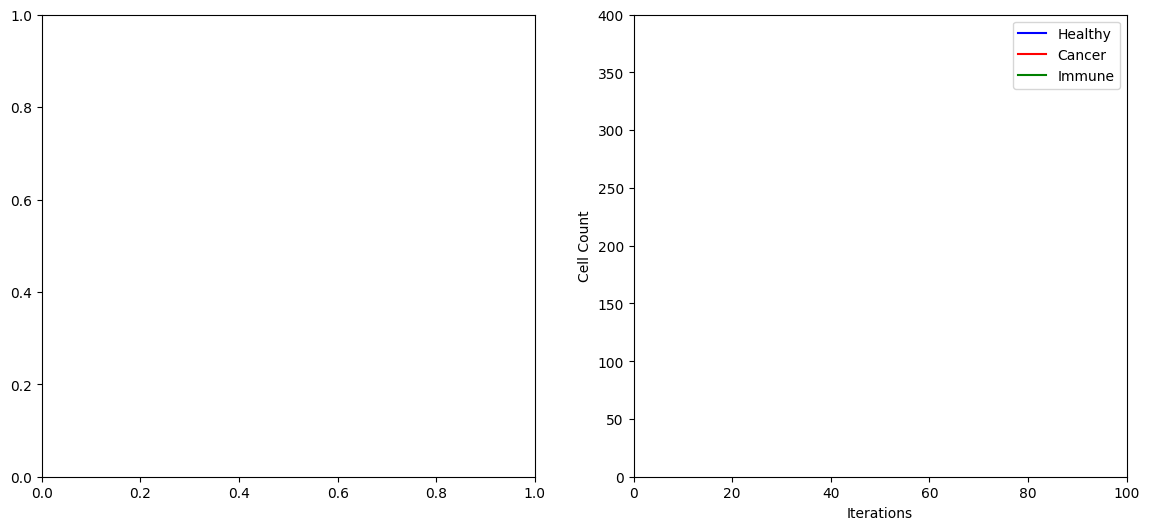

In [462]:
# Setup figure
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
line1, = ax2.plot([], [], 'b', label='Healthy')
line2, = ax2.plot([], [], 'r', label='Cancer')
line3, = ax2.plot([], [], 'g', label='Immune')
ax2.set_xlim(0, iterations)
ax2.set_ylim(0, grid_size ** 2)
ax2.set_xlabel("Iterations")
ax2.set_ylabel("Cell Count")
ax2.legend()

In [463]:
# Animation update function
def update(frame):
    global grid, healthy_counts, cancer_counts, immune_counts, cancer_positions
    total_cells = grid_size ** 2
    cancer_count = np.count_nonzero(grid == 2)

    # Stage 0: Add cancer cells progressively
    if cancer_count == 0 and frame % cancer_add_interval == 0:
        x, y = np.random.randint(0, grid_size, size=2)
        grid[x, y] = 2  # Add a random cancer cell
        initial_cancer_positions.append((x, y))

    # Determine stage
    stage = get_stage(cancer_count, total_cells)
    #print(f"Frame {frame}: Stage {stage}, Cancer Count: {cancer_count}")

    # Apply Markov transitions
    grid = apply_markov_transitions(grid, stage, immune_threshold)

    # Update counts
    healthy_counts.append(np.sum(grid == 1))
    cancer_counts.append(np.sum(grid == 2))
    immune_counts.append(np.sum(grid == 3))

    # Update plot
    time = np.arange(0, frame + 1)
    line1.set_data(time, healthy_counts)
    line2.set_data(time, cancer_counts)
    line3.set_data(time, immune_counts)

    draw_grid(grid, ax1)
    ax1.set_title(f"Cancer Simulation - Stage {stage}")
    return line1, line2, line3

ani = FuncAnimation(fig, update, frames=timesteps + 1, init_func=init, blit=True)
output_path = '/Users/leilamichal/Desktop/Simulations/cell_simulation.mp4'
writer = FFMpegWriter(fps=10, metadata={'title': 'Cancer Simulation with Graph'})
ani.save(output_path, writer=writer)
print(f"Animation saved to {output_path}")
plt.show

Animation saved to /Users/leilamichal/Desktop/Simulations/cell_simulation.mp4


<function matplotlib.pyplot.show(close=None, block=None)>